# PART II
The purpose of this document is to split the forcing data and the velocity results for a single member. First, we load in the relevant libraries and packages.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from glob import glob

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential
from utils import * 

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

plt.rcParams['savefig.dpi'] = 400
plt.rcParams['font.size'] = 13
plt.rcParams["legend.frameon"] = False

2022-11-24 23:06:00.656551: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def prepare_y(data_sets,time_reindex=True):
    if isinstance(data_sets, str):
        data_sets = [data_sets]
        
    Y_all = []
    length_all = []
    
    for file in data_sets:
        data_raw = xr.open_dataset(f"raw_data/velsurf_{file}_100yr_d1.nc",decode_times=False)
        data = data_raw.isel(time=np.arange(1000,len(data_raw.time),1)).drop(['lon','lat'])
        Y_all.append(data)
        length_all.append(len(data.time))
    
    length_all = np.array(length_all)
    Y = xr.concat(Y_all,dim='time')
    # Y = xr.concat([xr.open_dataset(data_path + f"outputs_{file}.nc") for file in data_sets], dim='time').mean("member")
    Y = Y.transpose('time','x', 'y')
    if time_reindex:
        Y = Y.assign_coords(time=np.arange(len(Y.time)))
    
    return Y, length_all

def prepare_x(data_sets,time_range,time_reindex=True):
    if isinstance(data_sets, str):
        data_sets = [data_sets]
        
    X_all      = []
    length_all = []
    
    for value in data_sets:
        data_raw = xr.open_dataset('timeseries_edc-wdc_temp.nc',decode_times=False)
        data = data_raw.interp(time=time_range)
        data['param'] = (['time'],value*np.ones(len(time_range)))
        X_all.append(data)
        length_all.append(len(data.time))
    
    X = xr.concat(X_all,dim='time')
    length_all = np.array(length_all)
    # X = xr.concat([xr.open_dataset(data_path + f"inputs_{file}.nc") for file in data_sets], dim='time')
    if time_reindex:
        X = X.assign_coords(time=np.arange(len(X.time)))

    return X, length_all

In [3]:
y_train_xr,y_length = prepare_y(['240','241','243'])
y_test_xr,_ = prepare_y(['242'],time_reindex=False)
y_test_xr['time'] = y_test_xr.time/31536000
year_range = y_test_xr.time

X_train_xr,X_length = prepare_x([1,2,4],year_range)
X_test_xr,_ = prepare_x([3],year_range,time_reindex=False)

In [32]:
X_train_df = pd.DataFrame({"delta_T": X_train_xr["delta_T"].data,
                           "param": X_train_xr["param"].data
                          }, index=X_train_xr["delta_T"].coords['time'].data)

X_test_df  = pd.DataFrame({"delta_T": X_test_xr["delta_T"].data,
                           "param": X_test_xr["param"].data
                          }, index=X_test_xr["delta_T"].coords['time'].data)


y_train_df = y_train_xr["velsurf_mag"].stack(dim=["x", "y"])
y_train_df = pd.DataFrame(y_train_df.to_pandas())

In [33]:
mean, std = X_train_df.mean(), X_train_df.std()

X_train_df   = (X_train_df - mean)/std
X_test_df    = (X_test_df - mean)/std

X_train = X_train_df.to_numpy()
y_train = y_train_df.to_numpy()
X_test = X_test_df.to_numpy()

print(X_train.shape,y_train.shape,X_test.shape)

(756, 2) (756, 145161) (252, 2)


In [34]:
start = np.cumsum(X_length) - X_length
end   = np.cumsum(X_length)

slider = 5
X_train_all = []
y_train_all = []

for i in range(len(X_length)):
    
    X_subset = X_train[start[i]:end[i],:]
    y_subset = y_train[start[i]:end[i],:]
    
    X_subset = np.array([X_subset[i:i+slider] for i in range(0, X_length[i]-slider+1)])
    y_subset = np.array([[y_subset[i+slider-1]] for i in range(0, X_length[i]-slider+1)])
    
    X_train_all.append(X_subset)
    y_train_all.append(y_subset)
    
X_train = np.concatenate(X_train_all,axis=0)
y_train = np.concatenate(y_train_all,axis=0)
X_test  = np.array([X_test[i:i+slider] for i in range(0, X_test.shape[0]-slider+1)])
print(X_train.shape,y_train.shape,X_test.shape)

(744, 5, 2) (744, 1, 145161) (248, 5, 2)


In [35]:
from tensorflow.keras import backend as K

def custom_rmse(y_true, y_pred):
    y_pred = y_pred[y_true >=0]
    y_true = y_true[y_true >=0]
    
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(y_true, y_pred.dtype)

    return K.sqrt(K.mean(tf.math.squared_difference(y_pred, y_true),axis= -1))

In [36]:
# set hyperparameters
n_neuron       = 32
activation     = 'relu'
num_epochs     = 100
learning_rate  = 0.005
minibatch_size = 32
model_num      = 1

In [37]:
lstm_model = Sequential()
lstm_model.add(LSTM(n_neuron,input_shape=(X_train.shape[1],X_train.shape[2]),
               return_sequences=True,activation=activation))
lstm_model.add(LSTM(n_neuron,return_sequences=False,
               activation=activation))
lstm_model.add(Reshape((1,32)))

lstm_model.add(Dense(n_neuron,activation=activation))
lstm_model.add(Dense(y_train.shape[-1],activation='linear')) 

lstm_model.compile(loss=custom_rmse,optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 5, 32)             4480      
                                                                 
 lstm_3 (LSTM)               (None, 32)                8320      
                                                                 
 reshape_1 (Reshape)         (None, 1, 32)             0         
                                                                 
 dense_2 (Dense)             (None, 1, 32)             1056      
                                                                 
 dense_3 (Dense)             (None, 1, 145161)         4790313   
                                                                 
Total params: 4,804,169
Trainable params: 4,804,169
Non-trainable params: 0
_________________________________________________________________


In [38]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

history = lstm_model.fit(X_train, y_train, 
                        batch_size = minibatch_size,
                        epochs = num_epochs,
                        validation_split=0.2, verbose=1,
                        callbacks=[early_stop],
                        shuffle=False)


Epoch 1/100
19/19 [==============================] - 3s 53ms/step - loss: 172.6731 - val_loss: 318.8339
Epoch 2/100
19/19 [==============================] - 0s 24ms/step - loss: 143.1422 - val_loss: 269.3539
Epoch 3/100
19/19 [==============================] - 0s 24ms/step - loss: 321.8795 - val_loss: 316.6013
Epoch 4/100
19/19 [==============================] - 0s 25ms/step - loss: 166.3083 - val_loss: 311.8210
Epoch 5/100
19/19 [==============================] - 0s 24ms/step - loss: 154.5624 - val_loss: 269.7143
Epoch 6/100
19/19 [==============================] - 0s 23ms/step - loss: 118.6352 - val_loss: 250.8002
Epoch 7/100
19/19 [==============================] - 0s 24ms/step - loss: 126.8419 - val_loss: 258.4469
Epoch 8/100
19/19 [==============================] - 0s 23ms/step - loss: 107.7201 - val_loss: 227.2482
Epoch 9/100
19/19 [==============================] - 0s 24ms/step - loss: 114.1222 - val_loss: 228.4726
Epoch 10/100
19/19 [==============================] - 0s 25ms/st

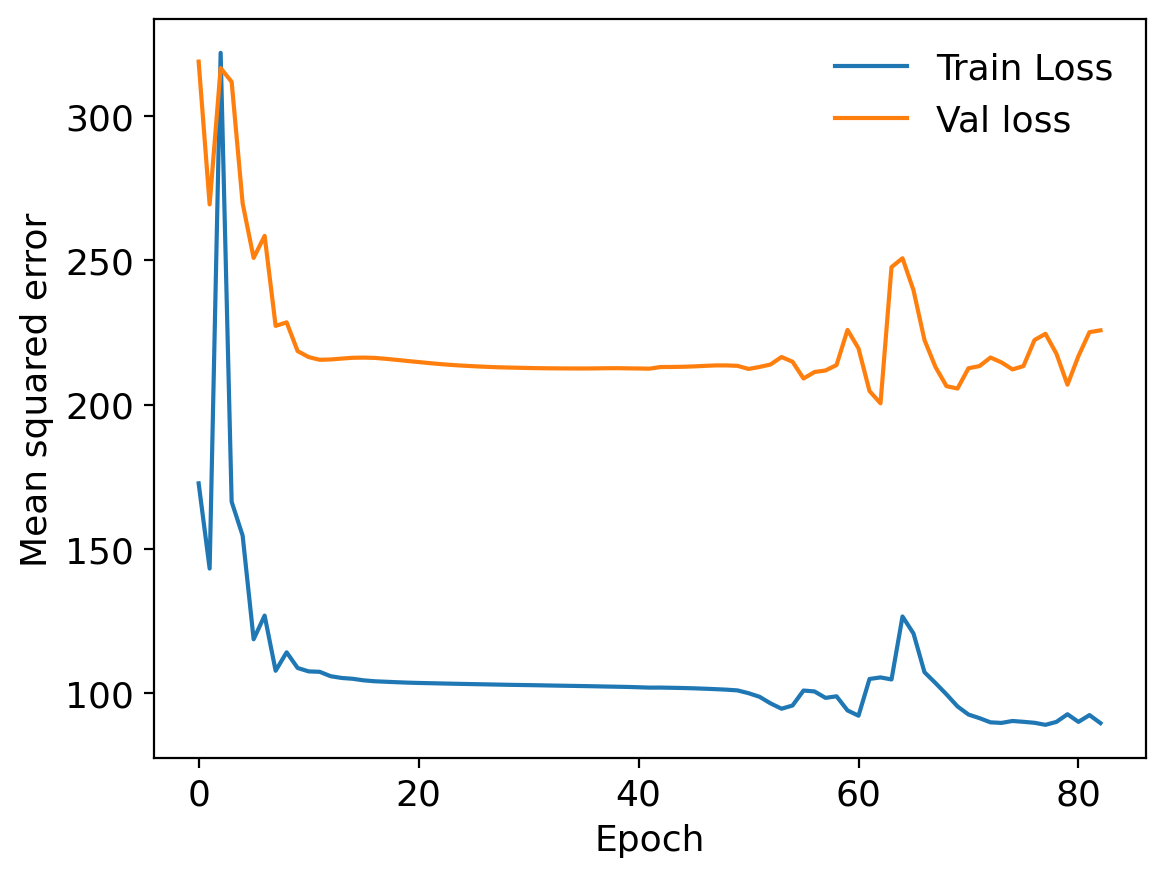

In [39]:
plot_history(history)

In [23]:
y_test_df = pd.DataFrame(y_test_xr.velsurf_mag.stack(dim=["y", "x"]).to_pandas())

In [24]:
y_test = y_test_df.to_numpy()

In [40]:
y_test_pre = lstm_model.predict(X_test)


8/8 [==============================] - 0s 3ms/step


In [41]:
y_test_pre_rs = y_test_pre.reshape(y_test_pre.shape[0],y_test_df.columns.levels[1].shape[0],y_test_df.columns.levels[0].shape[0])

y_test_pre_xr = xr.Dataset(coords={'time': X_test_xr.time.values[slider-1:], 
                               'x': y_test_df.columns.levels[1].values, 
                               'y': y_test_df.columns.levels[0].values},
                       data_vars=dict(velsurf_mag=(['time', 'y', 'x'], y_test_pre_rs)))

In [27]:
y_true =  y_test_df.unstack().to_xarray()

In [42]:
y_test_pre_xr = y_test_pre_xr + y_true - y_true

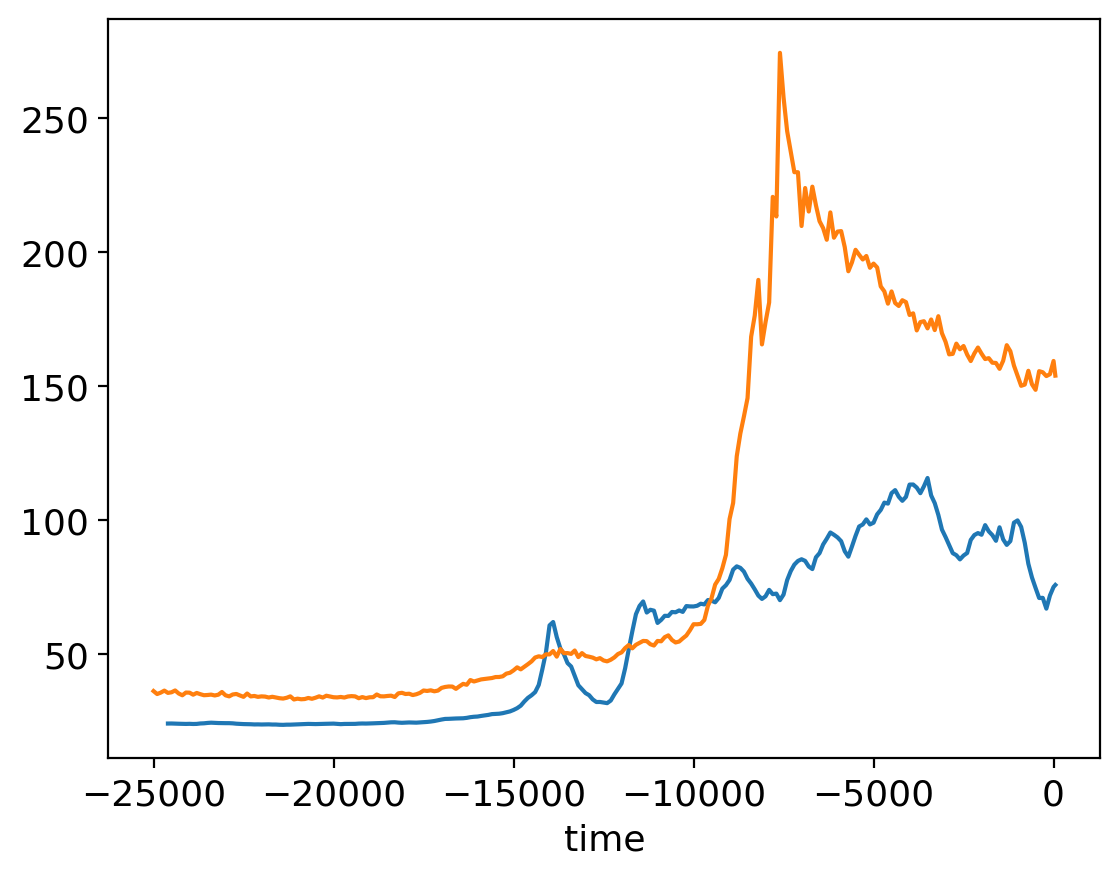

In [43]:
y_test_pre_xr.velsurf_mag.mean(dim=['x','y']).plot()
y_true.mean(dim=['x','y']).plot()